In [63]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.html.widgets import interact, FloatSlider

%matplotlib inline

# Chapter 1: Unconstrained convex optimization





Introduction ...

define unconstrained optimization and convex problems

## Backtracking line search

The outline of a general descent algorithm is given in the following pseudocode.

>**input** starting point $x\in$ **dom** $f$.
>
>**repeat** 
>
>>    1. Determine a descent direction $\Delta x$.
>>    2. *Line seach*. Choose a step size $t>0$.
>>    3. *Update*. $x:=x+t\Delta x$.
>
>**until** stopping criterium is satisfied.

>**output** $x$


The specific optimization algorithms are hence determined by:
- method for determining the step size $\Delta x$, this is usually based on the gradient of $f$
- method for choosing the step size $t$, may be fixed or adaptive
- the criterium used for terminating the descent, usually the algorthm stops when the improvement is smaller than a predefined value

### Exact line search

As a subroutine of the general descent algorithm a line search has to be performend. A $t$ is chosen to minimize $f$ along the ray $\{x+t\Delta x \mid t\geq0\}$:

$$
t = \text{argmax}_{s\geq0}\ f(x+t\Delta x)\,.
$$

Exact line search is used when the cost of solving the above minimization problem is small compared to the cost of calculating the search direction itself. This is sometimes the case when an analytical solution is available.

### Inexact line search

Often, the descent methods work well when the line search is done only approximately. This is because the computational resourches are better spend to performing more *approximate* steps in the differnt directions because the direction of descent will change anyway.

Many methods exist for this, we will consider the *backtracking line search*, described by the following pseudocode.

>**input** starting point $x\in$ **dom** $f$, descent direction $\Delta x$, $\alpha\in(0,0.05)$ and $\beta\in(0,1)$.
>
> $t:=0$
>
>**while** $f(x+t\Delta x) > f(x) +\alpha t \nabla f(x)^\intercal\Delta x$
>
>>    $t:=\beta t$
>

>**output** $t$

TO DO: explantion of BLS, figure to explain. Applet?

effect of $\alpha$ en $\beta$

**Assignment**
1. Complete the code for the backtracking line search
2. Use this function find the step size $t$ to (approximately) minimize $f(x) = x^3 - 2x - 5$ starting from the point $0$. Choose a $\Delta x=5$.

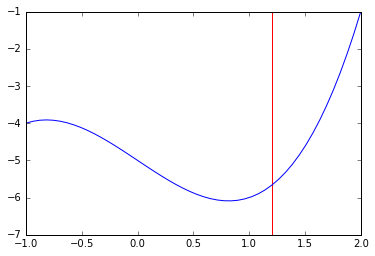

In [64]:
# SOLUTION

def backtracking_line_search(f, x0, Dx, grad_f, alpha=0.1, beta=0.7):
    '''
    Uses backtracking for finding the minimum over a line.
    Inputs: 
        - f: function to be searched over a line
        - x0: initial point
        - Dx: direction to search
        - grad_f: gradient of f
        - alpha
        - beta
    Output:
        - t: suggested stepsize
    '''
    t = 1
    while f(x0 + t * Dx) > f(x0) + alpha * t * np.sum(grad_f(x0) * Dx):
        t *= beta
    return t

function = lambda x : x**3 - 2*x - 5
gradient_function = lambda x : 3*x**2 - 2
Dx = 5

tbest = backtracking_line_search(function, 0, 5, gradient_function)

x = np.linspace(-1, 2)
fig, ax = plt.subplots()
ax.plot(x, function(x))
ax.vlines(0+tbest*Dx, -7, -1,'r')

## Gradient-based methods

### Some toy examples

To illustrate the algorithms, we introduce two toy functions to minimize:
    
- Simple quadratic problem:

$$
f(x_1, x_2) = \frac{1}{2} (x_1^2 +\gamma x_2^2)\,,
$$
where $\gamma$ determines the condition number.

- A non-quadratic function:
$$
f(x_1, x_2) = e^{x_1 +3x_2-0.1}+e^{x_1 -3x_2-0.1}+e^{-x_1 -0.1}\,.
$$

In [65]:
# some functions for visualisation

def plot_contour(f, xlim, ylim, ax):
    '''
    Plots the contour of a 2D function to be minimized
    '''
    xvals = np.linspace(*xlim)
    yvals = np.linspace(*ylim)
    X, Y = np.meshgrid(xvals, yvals)
    Z = np.reshape(list(map(f, zip(X.ravel().tolist(), Y.ravel().tolist()))), X.shape)
    ax.contour(X, Y, Z)
    ax.contourf(X, Y, Z, cmap='bone')


def add_path(ax, x_steps, col='b'):
    '''
    Adds a path of an opitmization algorithm to a figure
    '''
    ax.plot([x[0] for x in x_steps], [x[1] for x in x_steps], c=col)

In [66]:
# defining the quadric function, gradient and hessian

def quadratic(x, gamma=10):
    return 0.5 * (x[0]**2 + gamma * x[1]**2)

def grad_quadratic(x, gamma=10):
    return np.array([x[0], gamma * x[1]])

def hessian_quadratic(x, gamma=10):
    return np.array([[1, 0], [0, gamma]])

In [67]:
# defining the non-quadric function, gradient and hessian


x1_, x2_ = sp.symbols('x1, x2')

nonquad_expr = sp.log(sp.exp(x1_ + 3*x2_ - 0.1) + sp.exp(x1_-3*x2_-0.1) + sp.exp(-x1_ - 0.1))
nonquadratic_f = sp.lambdify((x1_, x2_), nonquad_expr, np)
nonquadratic = lambda x : nonquadratic_f(x[0],x[1])
grad_nonquadratic_f = sp.lambdify((x1_, x2_), [nonquad_expr.diff(x1_), nonquad_expr.diff(x2_)], np)
grad_nonquadratic = lambda x : np.array(grad_nonquadratic_f(x[0], x[1]))

nqdx1dx1 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x1_), np)
nqdx1dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x2_), np)
nqdx2dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x2_).diff(x2_), np)

def hessian_nonquadratic(x):
    return np.array([[nqdx1dx1(x[0,:], x[1,:]), nqdx1dx2(x[0,:], x[1,:])], 
                     [nqdx1dx2(x[0], x[1]), nqdx2dx2(x[0], x[1])]]).reshape(2,2)

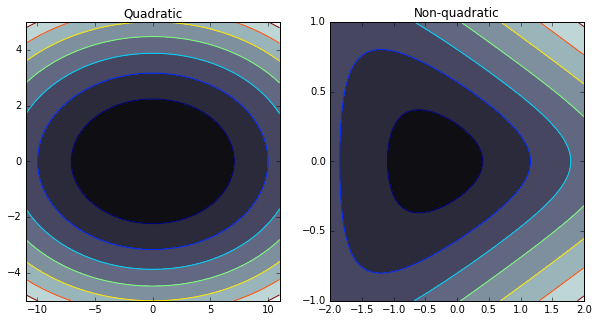

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
ax1.set_title('Quadratic')
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)
ax2.set_title('Non-quadratic')

## Gradient descent

A natural choise for the search direction is the negative gradient: $\Delta x = -\nabla f(x)$. This algorithm is called the *gradient descent algorithm*.

>**input** starting point $x\in$ **dom** $f$.
>
>**repeat** 
>
>>    1. $\Delta x := -\nabla f(x)$.
>>    2. *Line seach*. Choose a step size $t$ via exact or backtracking line search.
>>    3. *Update*. $x:=x+t\Delta x$.
>
>**until** stopping criterium is satisfied.

>**output** $x$

The stopping criterium is usually of the form $||\nabla f(x)||_2 \leq \nu$.

#### Convergence analysis

**Put here some very complicated mathematics**

**Assignment**
1. Complete the code for the gradient descent algorithm.
2. Find the minima of the two toy problems.

In [69]:
# SOLUTION

def gradient_descent(f, x0, grad_f, alpha=0.05, beta=0.6, nu=1e-3, trace=False):
    '''
    General gradient descent algorithm.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - grad_f: gradient of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algortihm is convered
        - trace: (bool) store the path that is followed?
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x0.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        Dx = - grad_f(x)  # choose direction
        if np.linalg.norm(grad_f(x)) <= nu:
            break  # converged
        t = backtracking_line_search(f, x, Dx, grad_f, alpha, beta)
        x += t * Dx
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps
    else: return x

Number of steps quadratic function: 64
Number of steps non-quadratic function: 27


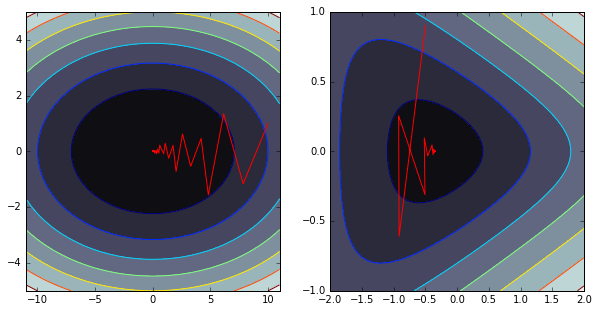

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = gradient_descent(quadratic, np.array([[10.0], [1.0]]), 
                                                 grad_quadratic, nu=1e-5, trace=True)
add_path(ax1, x_steps_q, 'red')

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = gradient_descent(nonquadratic, np.array([[-0.5], [0.9]]),
                                                    grad_nonquadratic, nu=1e-5, trace=True)
add_path(ax2, x_steps_nq, 'red')

print('Number of steps non-quadratic function: {}'.format(len(f_steps_nq) - 1))

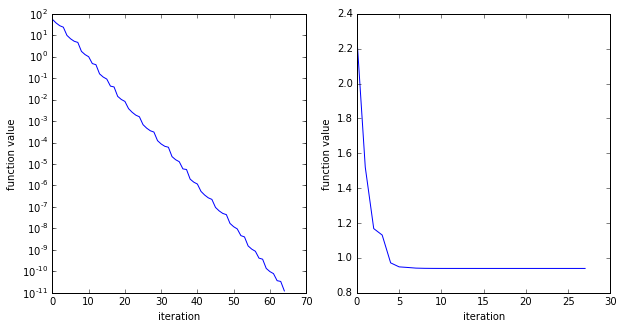

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q)
ax1.semilogy()
ax2.plot(f_steps_nq)

for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

Discussion scalability?

## Newton's method

In Newton's method the descent direction is chosen as

$$
\Delta x_\text{nt} = -\nabla^2f(x)^{-1} \nabla f(x)\,,
$$
which is called the *Newton step*. Here $\nabla^2f(x)^{-1}$ is the inverse of the Hessian of $f$.

If $f$ is convex, then $\nabla^2f(x)$ is positive definite and
$$
\nabla f(x)^\intercal \Delta x_\text{nt} \geq 0\,,
$$
hence the Newton step is a descent direction unless $x$ is optimal.

This Newton step can be motivated in several ways.

### Motivation 1: minimizer of a second order approximation

The second order Taylor approximation $\hat{f}$ of $f$ at $x$ is

$$
\hat{f}(x+v) = f(x) + \nabla f(x)^\intercal v + \frac{1}{2} v^\intercal \nabla^2 f(x) v\,
$$

which is a convex quadratic function of $v$, and is minimized when $v=\Delta x_\text{nt}$.

This quadratic model will be particulary accuate when $x$ is near the minimum.

### Motivation 2: affine invariance of the Newton step

to be completed

### Newton decrement

The Newton decrement is defined as
$$
\lambda(x)  = (\nabla f(x)^\intercal\nabla^2 f(x)\nabla f(x))^{1/2}\,.
$$

This can be related to the quantity $f(x)-\text{inf}_y\ \hat{f}(y)$:
$$
f(x)-\text{inf}_y\ \hat{f}(y) = f(x) - \hat{f}(x +\Delta x_\text{nt}) = \frac{1}{2} \lambda(x)^2\,.
$$
Thus $\frac{1}{2} \lambda(x)^2$ is an istimate of $f(x) - p^*$, based on the quadratic approximation of $f$ at $x$. 

### Pseudocode of Newton's algorithm

>**input** starting point $x\in$ **dom** $f$.
>
>**repeat** 
>
>>    1. Compute the Newton step and decrement $\Delta x_\text{nt} := -\nabla^2f(x)^{-1} \nabla f(x)$; $\lambda^2:=\nabla f(x)^\intercal\nabla^2 f(x)\nabla f(x)$. 
>>    2. *Stopping criterium* **break** if $\lambda^2/2 \leq \epsilon$.
>>    2. *Line seach*. Choose a step size $t$ via exact or backtracking line search.
>>    3. *Update*. $x:=x+t\Delta x$.
>
>**until** stopping criterium is satisfied.

>**output** $x$

The above algorithm is sometimes called the *damped* Newton method, as it uses a variable step size $t$.

### Convergence analysis

Difficult math goes **here**

**Assignment**
1. Complete the code for the gradient descent algorithm.
2. Find the minima of the two toy problems.

In [72]:
# SOLUTION

def newtons_method(f, x0, grad_f, hess_f, alpha=0.3, beta=0.8, epsilon=1e-3, trace=False):
    '''
    Newton's method for minimizing functions.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - grad_f: gradient of the function to be minimized
        - hess_f: hessian matrix of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algortihm is convered
        - trace: (bool) store the path that is followed?
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        Dx = - np.linalg.solve(hess_f(x), grad_f(x))
        if grad_f(x).T.dot(grad_f(x))/2 <= epsilon:   # stopping criterium
            break  # converged
        t = backtracking_line_search(f, x, Dx, grad_f, alpha, beta)
        x += Dx * t
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps    
    else: return x

Number of steps quadratic function: 1
Number of steps non-quadratic function: 5


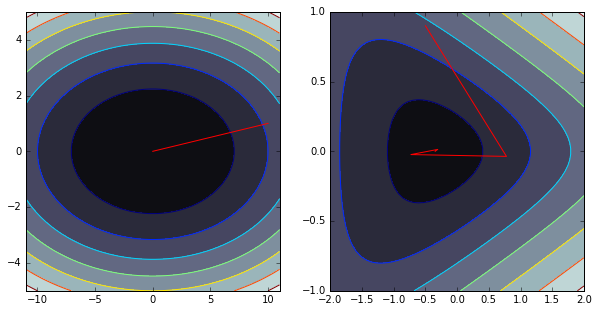

In [73]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = newtons_method(quadratic, np.array([[10.0], [1.0]]),
                                grad_quadratic, hessian_quadratic, epsilon=1e-8, trace=True)
add_path(ax1, x_steps_q, 'red')

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = newtons_method(nonquadratic, np.array([[-0.5], [0.9]]), 
                                grad_nonquadratic, hessian_nonquadratic, epsilon=1e-8, trace=True)
add_path(ax2, x_steps_nq, 'red')

print('Number of steps non-quadratic function: {}'.format(len(x_steps_nq) - 1))

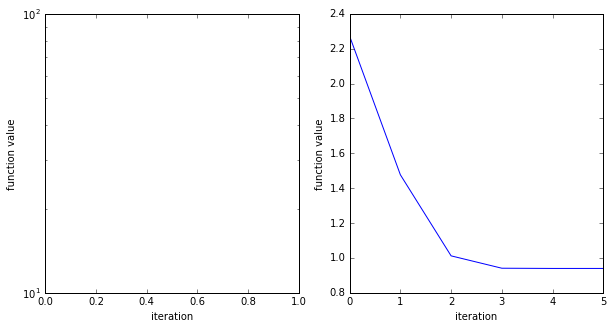

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q)
ax1.semilogy()
ax2.plot(f_steps_nq)

for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

#### Effect of condtition number

Compare gradient descent vs Newton's algorithm when changing the condition number.

In [75]:
def show_condition(gamma):
    quad_gamma = lambda x : quadratic(x, gamma)
    d_quad_gamma = lambda x : grad_quadratic(x, gamma)
    dd_quad_gamma = lambda x : hessian_quadratic(x, gamma)
    xstar_gd, x_steps_gd, f_steps_gd = gradient_descent(quad_gamma, np.array([10., 1.]),\
                                                     d_quad_gamma, nu=1e-6, trace=True)
    xstar_nm, x_steps_nm, f_steps_nm = newtons_method(quad_gamma, np.array([10., 1.]),\
                                                   d_quad_gamma, dd_quad_gamma, epsilon=1e-6, trace=True)
    fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10))
    plot_contour(quad_gamma, [-10, 10], [-11, 11], ax1)
    add_path(ax1, x_steps_gd, 'b')
    add_path(ax1, x_steps_nm, 'r')
    print('gradient descent iterations: {}'.format(len(x_steps_gd)))
    print('Newton\'s iterations: {}'.format(len(x_steps_nm)))

gradient descent iterations: 2
Newton's iterations: 2


<function __main__.show_condition>

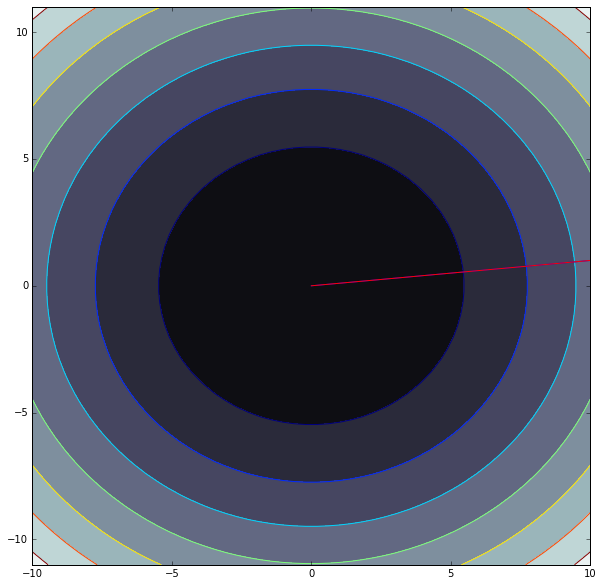

In [76]:
interact(show_condition, gamma=FloatSlider(min=0.1, max=20.0, step=0.1, value=1))

### Summary Newton's method
- Convergence of Newton's algorithm is rapid and quadratic near $x^*$
- Newton's algorithm is affine invariant, e.g. invariant to choice of coordinates or condition number
- Newton's algorithm scales well with problem size
- The hyperparameters $\alpha$ and $\beta$ do not infuence the performance much.

## Quasi-Newton methods

to be completed

- Hessian cannot calculated or be stored
- approximation!
- Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm

In [77]:
from scipy.optimize import minimize

x_steps_q = [np.array([10.0, 1.0])]
result_q_bfgs = minimize(quadratic, np.array([10.0, 1.0]), jac=grad_quadratic,
                         method='BFGS', callback=lambda x : x_steps_q.append(x))

f_steps_q = list(map(quadratic, x_steps_q))

print('Number of steps quadratic function: {}'.format(len(x_steps_q)))

x_steps_nq = [np.array([-0.5, 0.9])]
result_nq_bfgs = minimize(nonquadratic, np.array([-0.5, 0.9]), jac=grad_nonquadratic,
                          method='BFGS', callback=lambda x : x_steps_nq.append(x))

print('Number of steps non-quadratic function: {}'.format(len(x_steps_nq)))

f_steps_nq = list(map(quadratic, x_steps_nq))

Number of steps quadratic function: 4
Number of steps non-quadratic function: 8


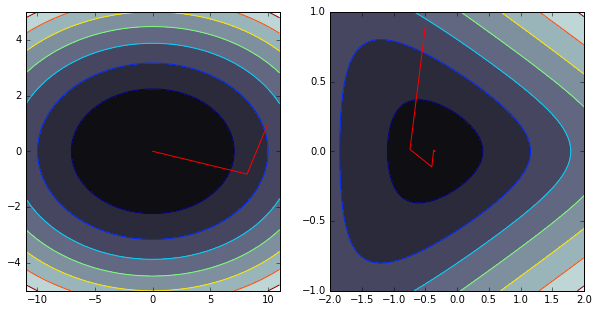

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

add_path(ax1, x_steps_q, 'red')
add_path(ax2, x_steps_nq, 'red')

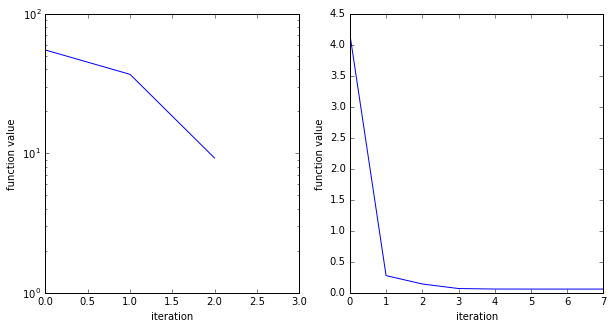

In [79]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q)
ax1.semilogy()
ax2.plot(f_steps_nq)

for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

# Project: logistic regression

In this project we will use gradient-based optimization to train a logistic regression model.

Consider the following problem: we have a dataset of $n$ instances $(\mathbf{x}_i, y_i)$ with $i\in 1\ldots n$. Here $\mathbf{x}_i\in \mathbb{R}^p$ is a $p$-dimensional feature vector and $y_i\in\{0,1\}$ is a binary label. This a a binary classification problem, we are interested in predicting the label of an instance based on its feature description. The goal of logistic regression is to find a function $f(\mathbf{x})$ that estimates the conditional probability of $Y$:

$$
\mathcal{P}(Y=1 \mid \mathbf{X} = \mathbf{x})\,.
$$

We will assume that this function $f(\mathbf{x})$ is of the form

$$
f(\mathbf{x}) = \sigma(\mathbf{w}^\intercal\mathbf{x})\,,
$$

with $\mathbf{w}$ a vector of parameters to be learned and $\sigma(.)$ the logistic map:

$$
\sigma(t) = \frac{e^{-t}}{1+e^{-t}}\,.
$$

It is easy to see that the logistic mapping will ensure that $f(\mathbf{x})\in[0, 1]$, hence $f(\mathbf{x})$ can be interpretated as a probability. 

To find the best weights that separate the two classes, we can use the following loss function:

$$
\mathcal{L}(\mathbf{w})=-\sum_{i=1}^n[y_i\log(\sigma(\mathbf{w}^\intercal\mathbf{x}_i))+(1-y_i)\log(1-\sigma(\mathbf{w}^\intercal\mathbf{x}_i))] +\lambda \mathbf{w}^\intercal\mathbf{w}\,.
$$

Here, the first part is the cross entropy, which penalized disagreement between the prediction $f(\mathbf{x}_i$ and the true label $y_i$, while the second term penalizes complex models in which $\mathbf{w}$ has a large norm. The trade-off between these two components is controlled by $\lambda$, a hyperparameters. In the course *Predictive modelling* it is explained that by carefully tuning this parameter one can obtain an improved performance. **For this course we will study the influence $\lambda$ on the convergence of the optimization algorithms.**

Below is a toy example in two dimensions illustrating the loss function.

In [80]:
X1_cent = np.random.multivariate_normal([0, 0],  [[2, 1], [1, 3]], 20)
X2_cent = np.random.multivariate_normal([0, 0],  [[2, 1], [1, 3]], 20)

direction = np.array([1, -1.2])

sigmoid = lambda t : np.exp(-t) / (1 + np.exp(-t))

def logistic_toy(separation=0, log_lambda=1):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    X1 = X1_cent - separation * direction/2
    X2 = X2_cent + separation * direction/2
    ax0.scatter(X1[:,0], X1[:,1], c='orange', s=50, label='class 1')
    ax0.scatter(X2[:,0], X2[:,1], marker='^', c='blue', s=50, label='class 2')
    ax0.legend(loc=0)
    ax0.set_xlabel('x1')
    ax0.set_ylabel('x2')
    
    loss_toy = lambda w : np.sum(np.log(sigmoid(X1.dot(w)))) + np.sum(np.log(1 - sigmoid(X2.dot(w)))) + 10**log_lambda * np.sum(np.array(w)**2)
    plot_contour(loss_toy, (-4, 4), (-4, 4), ax1)
    ax1.set_xlabel('w1')
    ax1.set_ylabel('w2')

<function __main__.logistic_toy>

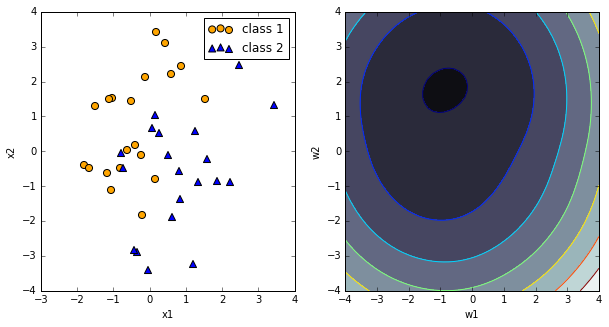

In [81]:
interact(logistic_toy, separation=FloatSlider(min=0, max=4, step=0.2, value=1), 
         log_lambda=FloatSlider(min=-5, max=5, step=1, value=1))